# Impact of 401(k) on Financial Assets

## Data explanation
1991 Survey of Income and Program Participation

- **net_tfa** — *Net Total Financial Assets*.
  Calculated as the sum of all liquid and interest-earning assets (IRA balances, 401(k) balances, checking accounts, U.S. savings bonds, other interest‐earning accounts, stocks, mutual funds, etc.) **minus** non‐mortgage debts.

- **e401** — *401(k) Eligibility Indicator*.
  Equals 1 if the individual's employer offers a 401(k) plan; otherwise 0.

- **p401** — *401(k) Participation Indicator*.
  Equals 1 if the individual participate in 401(k) plan; otherwise 0.

- **age** — *Age*.
  Age of the individual in years.

- **inc** — *Annual Income*.
  Annual income of the individual, measured in U.S. dollars for the year 1990.

- **educ** — *Years of Education*.
  Number of completed years of formal education.

- **fsize** — *Family Size*.
  Total number of persons living in the household.

- **marr** — *Marital Status*.
  Equals 1 if the individual is married; otherwise 0.

- **twoearn** — *Two-Earner Household*.
  Equals 1 if there are two wage earners in the household; otherwise 0.

- **db** — *Defined-Benefit Pension Plan*.
  Equals 1 if the individual is covered by a defined-benefit pension plan; otherwise 0.

- **pira** — *IRA Participation*.
  Equals 1 if the individual contributes to an Individual Retirement Account (IRA); otherwise 0.

- **hown** — *Home Ownership*.
  Equals 1 if the household owns its home; 0 if renting.

We download it with fetch_401K function from doubleML.datasets

This dataset has a problem. confounders were measured in the same year as treatment and outcome,
 like they are demographic factors that do not change over time. So inference might still be biased.

In [1]:
from doubleml.datasets import fetch_401K
from warnings import filterwarnings
df = fetch_401K(return_type='DataFrame')

/Users/ioannmartynov/miniconda3/envs/causalkit/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# don't know what they mean
df = df.drop(columns=['tw', 'nifa'])
# eligibility for 401k, drop because it's an instrument
df = df.drop(columns=['e401'])

df.columns

Index(['net_tfa', 'age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn',
       'p401', 'pira', 'hown'],
      dtype='object')

In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df=df, treatment='p401',
                         outcome='net_tfa',
                         confounders=['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn', 'pira', 'hown'])

## EDA

In [4]:
from causalis.shared import outcome_stats

# 1) Outcome shared by treatment
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0,7321,10890.477539,55256.829173,-502302.0,-5427.0,-1184.0,200.0,7399.0,33500.0,1462115.0
1,1,2594,38262.058594,79087.535303,-283356.0,-1300.0,3000.0,15249.0,45985.5,98887.4,1536798.0


Participants’ average net worth is ≈28k higher, but this gap cannot be causally attributed
solely to participation. The classes are imbalanced—only 26% are treated.

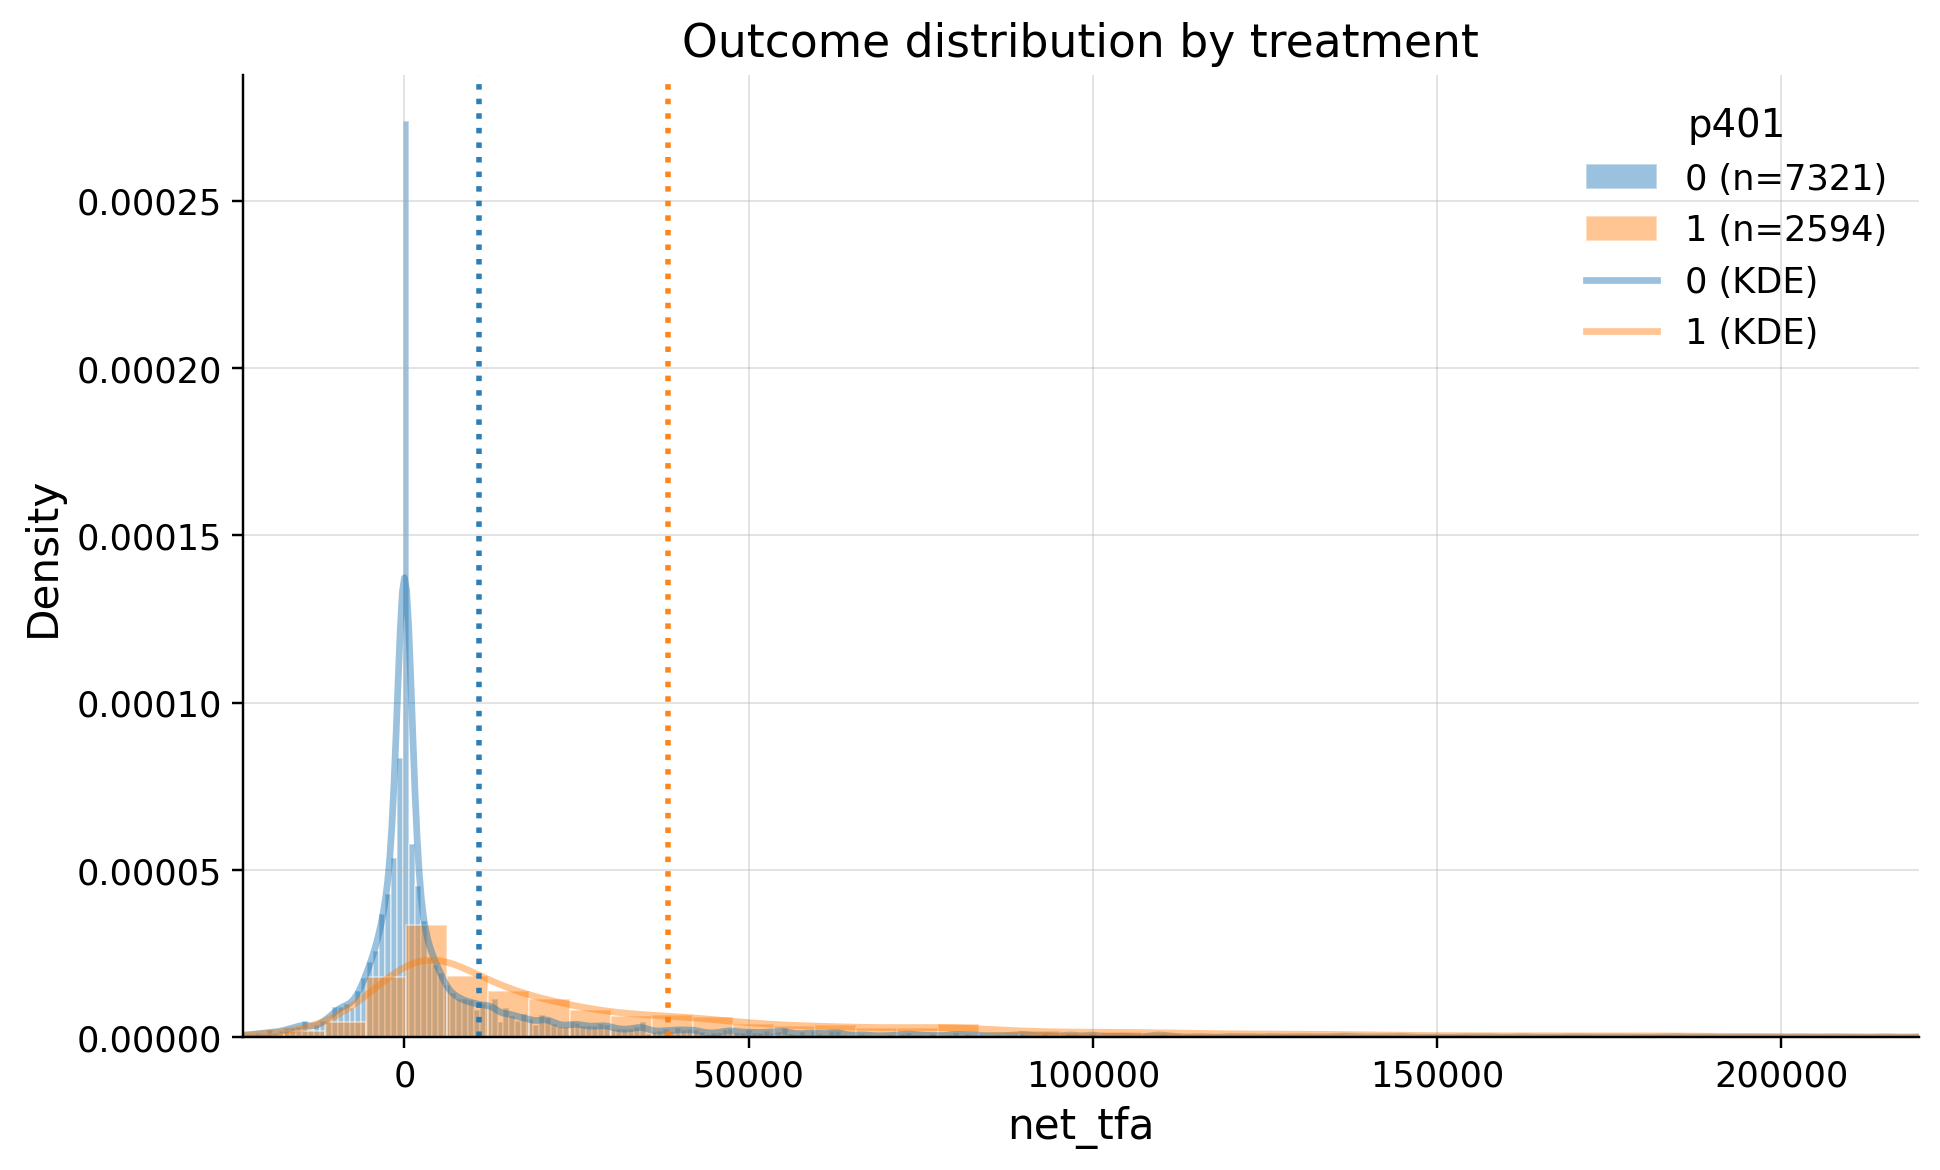

In [5]:
from causalis.shared.outcome_plots import outcome_plot_dist

outcome_plot_dist(causaldata)

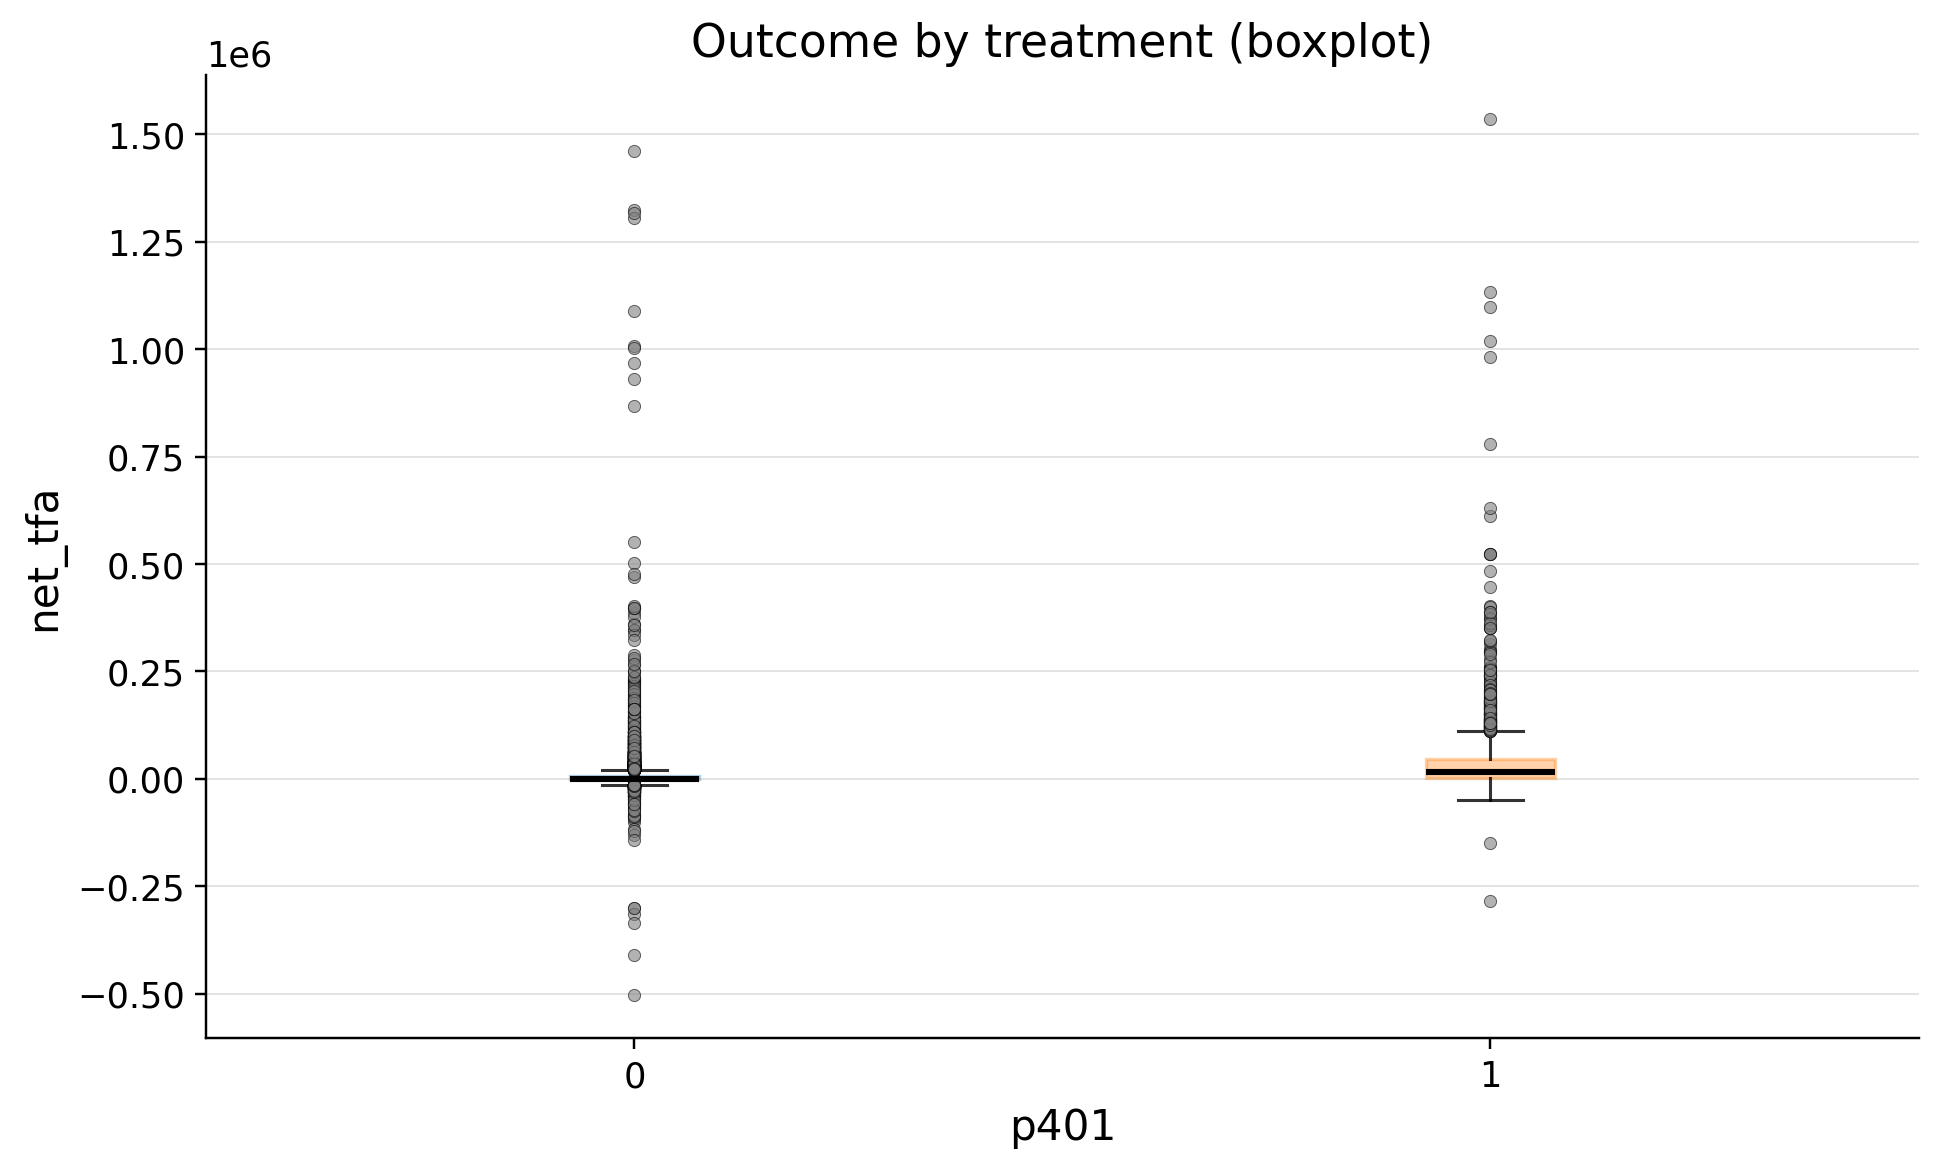

In [6]:
from causalis.shared.outcome_plots import outcome_plot_boxplot

outcome_plot_boxplot(causaldata)

Our outcome has large right tail

In [7]:
from causalis.shared import outcome_outliers

outcome_outliers(causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,0,7321,1292,0.176479,-14058.50,20273.50,True,iqr,both
1,1,2594,212,0.081727,-61478.25,110463.75,True,iqr,both


In [8]:
from causalis.shared import confounders_balance

# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,inc,32889.802486,49366.975713,16477.173227,0.662197,0.00000
1,hown,0.589127,0.765227,0.176100,0.383456,0.00000
2,pira,0.200246,0.360447,0.160201,0.362421,0.00000
3,db,0.228248,0.391673,0.163426,0.358968,0.00000
4,twoearn,0.337659,0.502699,0.165040,0.339096,0.00000
5,educ,12.991121,13.813416,0.822294,0.299061,0.00000
6,marr,0.574512,0.690439,0.115928,0.242175,0.00000
7,age,40.900970,41.509638,0.608668,0.060108,0.00000
8,fsize,2.848108,2.915960,0.067852,0.044731,0.00076


Treatment and control are unbalanced on all confounders except age and fsize; nonetheless,
we retain age and fsize in the model to gain efficiency

## Inference

In [13]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)
dml_result = model.estimate(score='ATE')
dml_result.summary()

,value
field,
estimand,ATE
model,IRM
value,"11027.1737 (ci_abs: 8241.3361, 13813.0113)"
value_relative,"79.0032 (ci_rel: 53.3308, 104.6757)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,2594
n_control,7321


Average Treatment Effect is significant and equals 12486.5221 (ci_abs: 9791.0517, 15181.9924)

## Refutation

## Unconfoundedness

In [14]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.unconfoundedness_validation import run_unconfoundedness_diagnostics

rep_uc = run_unconfoundedness_diagnostics(causaldata ,dml_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.071103,GREEN
1,balance_frac_violations,0.000000,GREEN


### Sensitivity

In [15]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

In [16]:
sensitivity_benchmark(dml_result, benchmarking_set =['inc'])

,r2_y,r2_d,rho,theta_long,theta_short,delta
p401,0.000038,9.626565e-08,1.0,11027.17369,14961.333165,-3934.159474


In [17]:
sensitivity_analysis(dml_result, r2_y=0.000038, r2_d=9.626565e-08, rho=1.0, alpha=0.05)

{'theta': 11027.173690133526,
 'se': 1421.3718379696486,
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': (8241.336079073513, 13813.01130119354),
 'theta_bounds_cofounding': (11026.878096998567, 11027.469283268485),
 'bias_aware_ci': (8241.052409910035, 13813.318820768469),
 'max_bias_base': 154546.29526314724,
 'max_bias': 0.29559313495817796,
 'bound_width': 0.29559313495817796,
 'sigma2': 3792734186.778151,
 'nu2': 6.29745091623553,
 'rv': 0.06659988318083149,
 'rva': 0.05062630379913903,
 'params': {'r2_y': 3.8e-05,
  'r2_d': 9.626565e-08,
  'rho': 1.0,
  'use_signed_rr': False}}

## SUTVA

In [18]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Score

In [19]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(causaldata, dml_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,1.421372e+03,NA
1,psi_p99_over_med,3.625835e+01,RED
2,psi_kurtosis,1.700952e+02,RED
3,max_|t|_g1,3.709872e+00,YELLOW
4,max_|t|_g0,1.989905e+00,GREEN
5,max_|t|_m,2.116322e+00,YELLOW
6,oos_tstat_fold,2.643408e-16,GREEN
7,oos_tstat_strict,1.982299e-16,GREEN


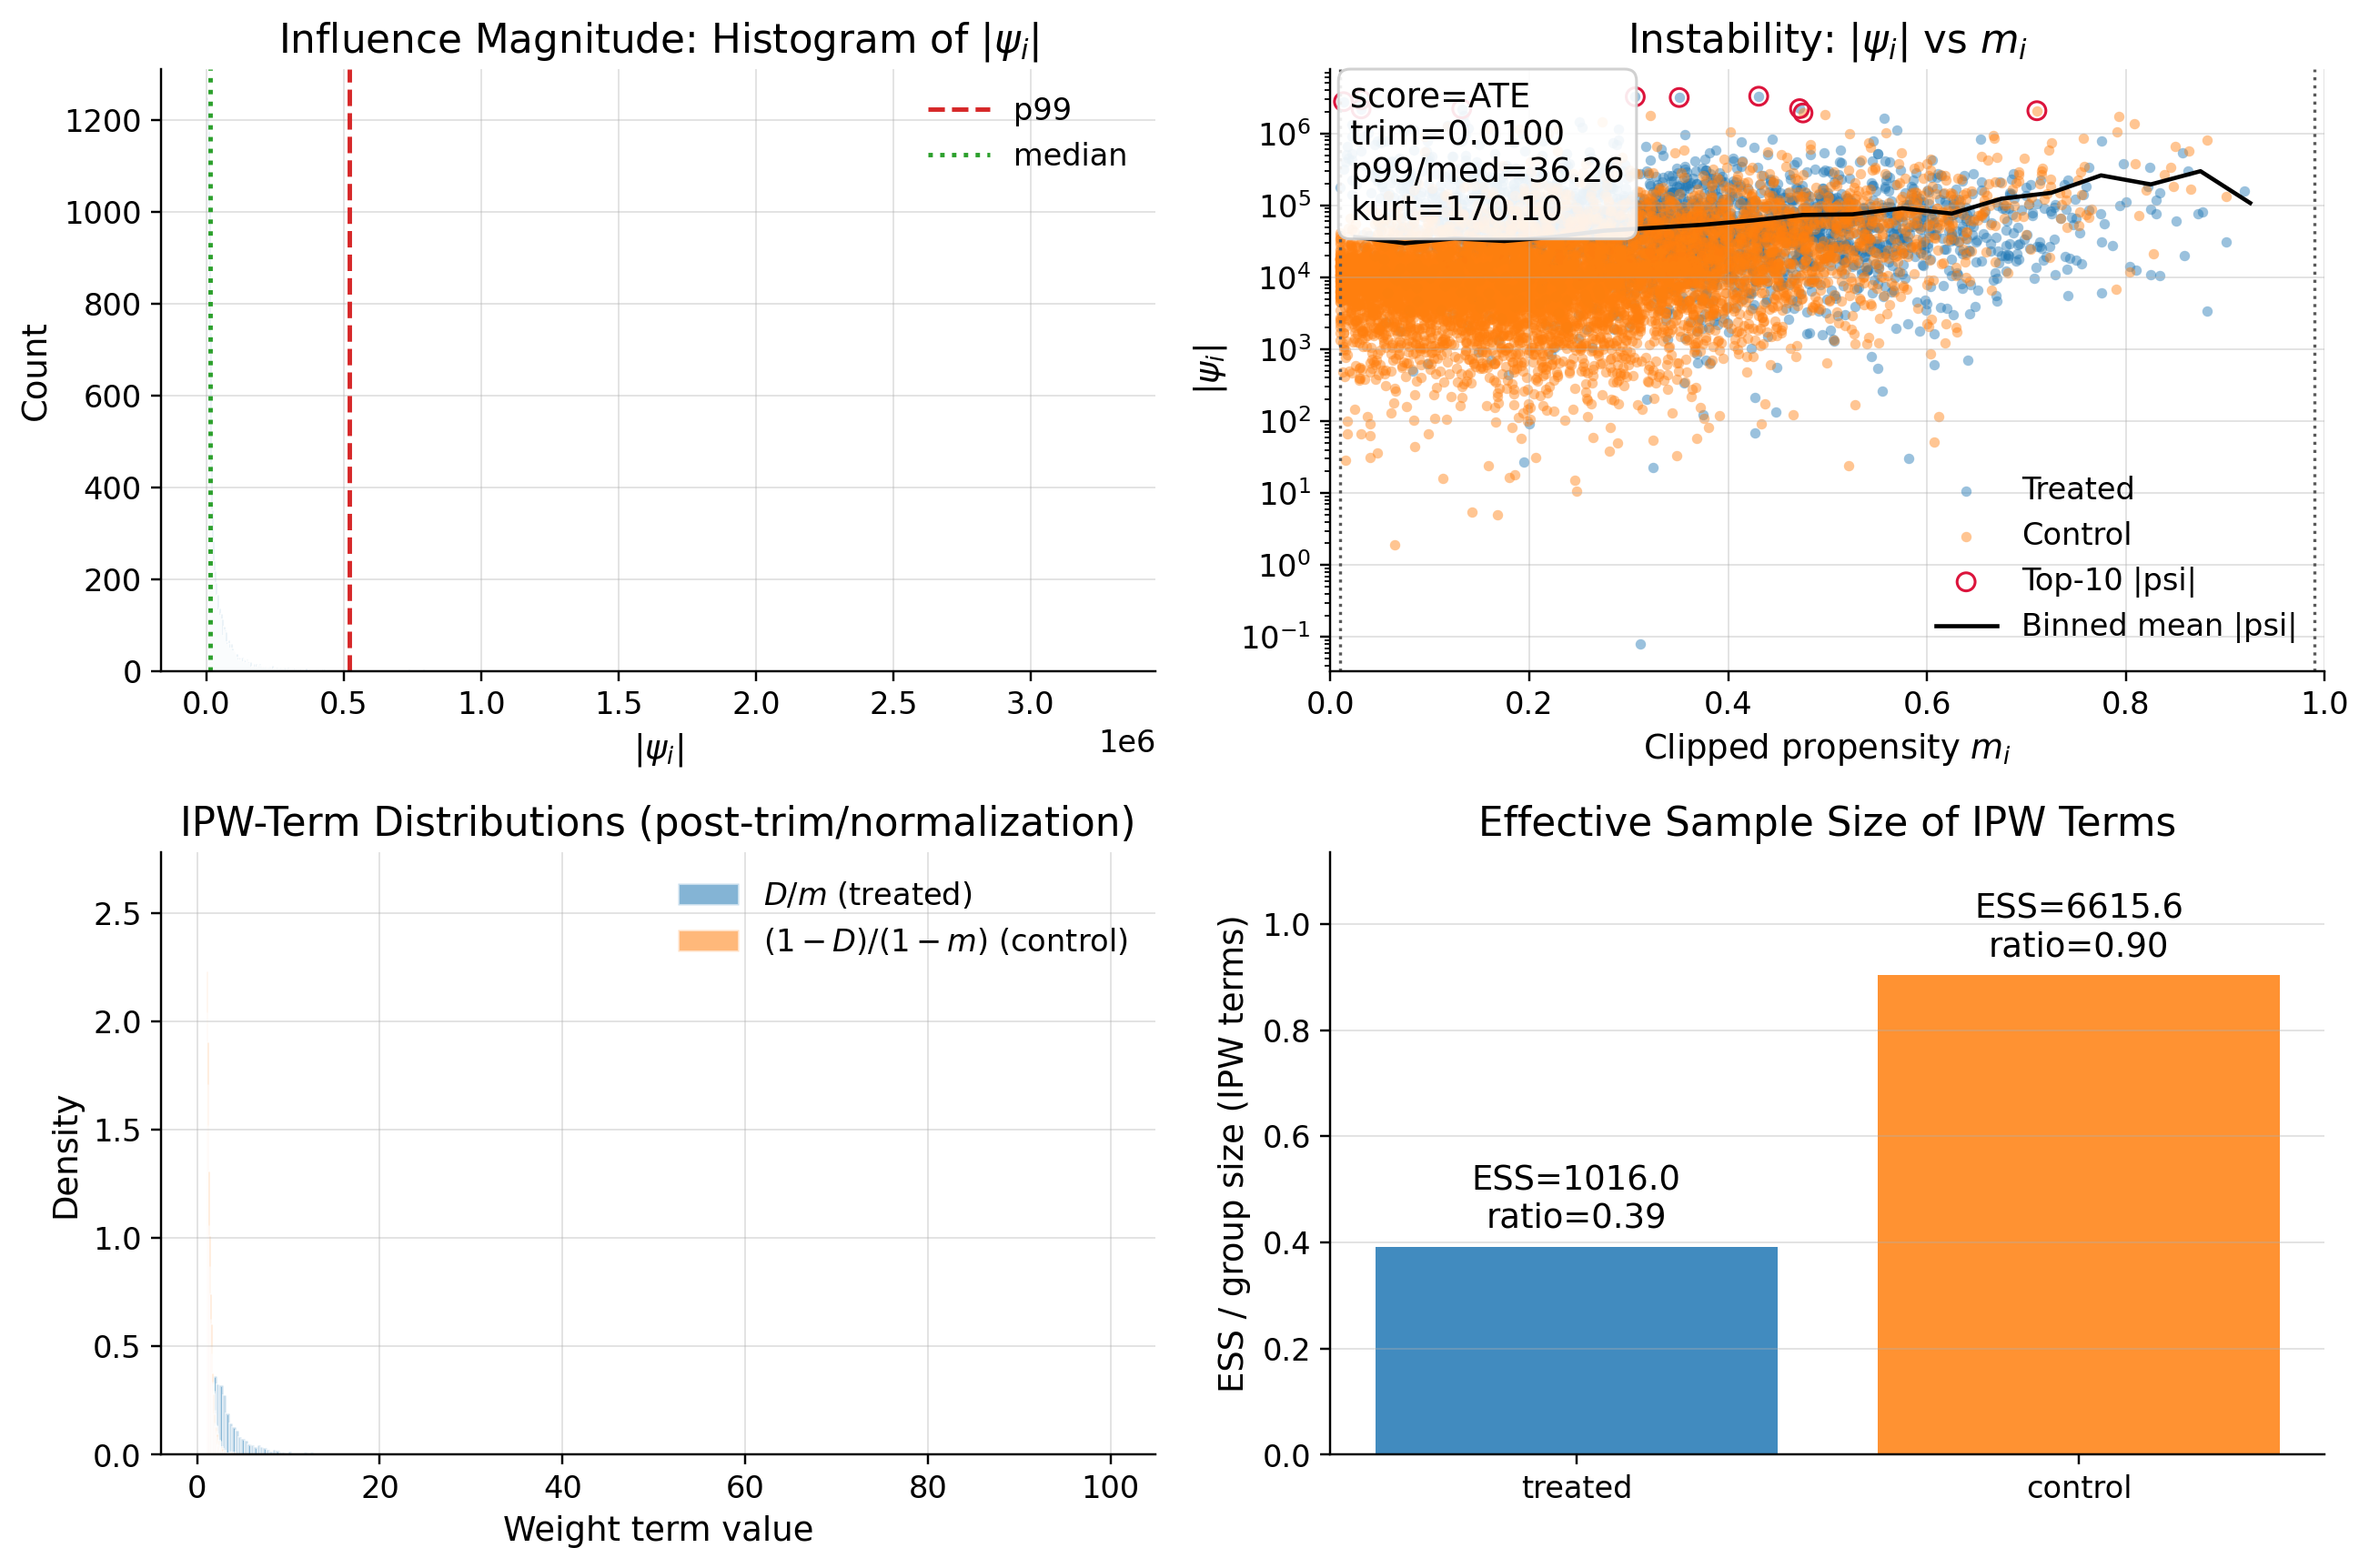

In [20]:
from causalis.scenarios.unconfoundedness.refutation import plot_influence_instability
plot_influence_instability(dml_result)

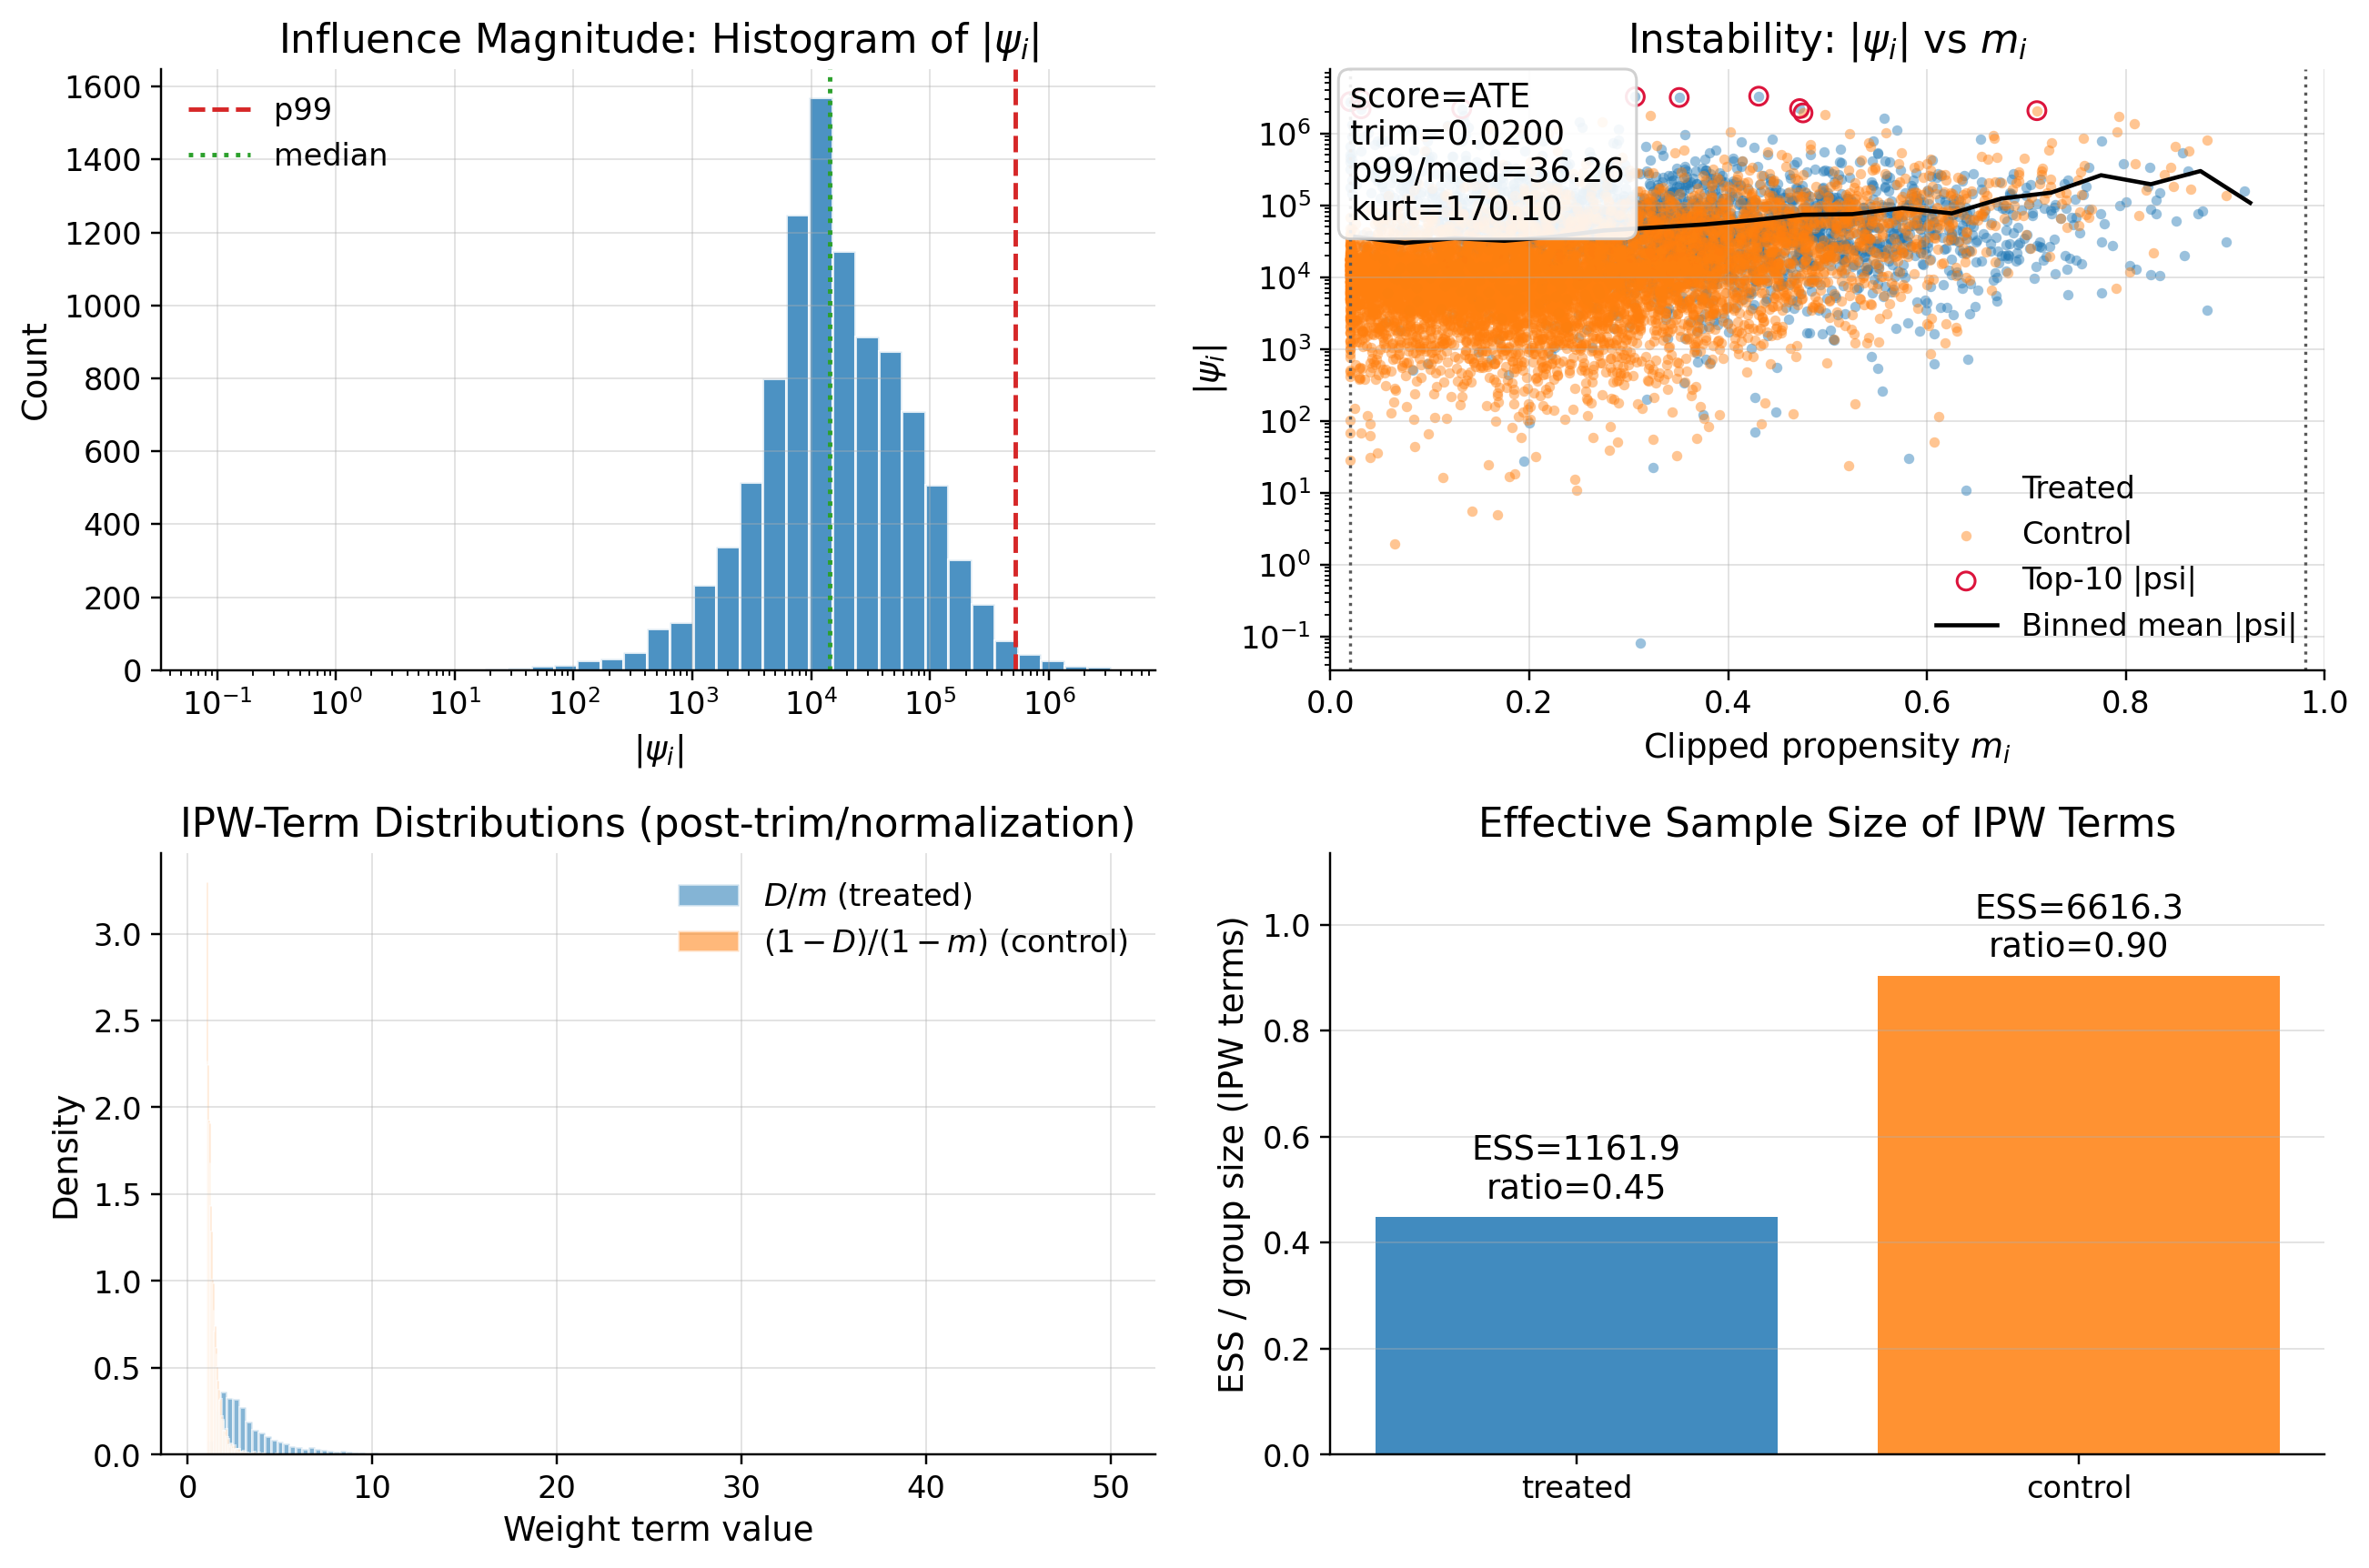

In [21]:
plot_influence_instability(dml_result, log_hist=True, trimming_threshold=0.02)

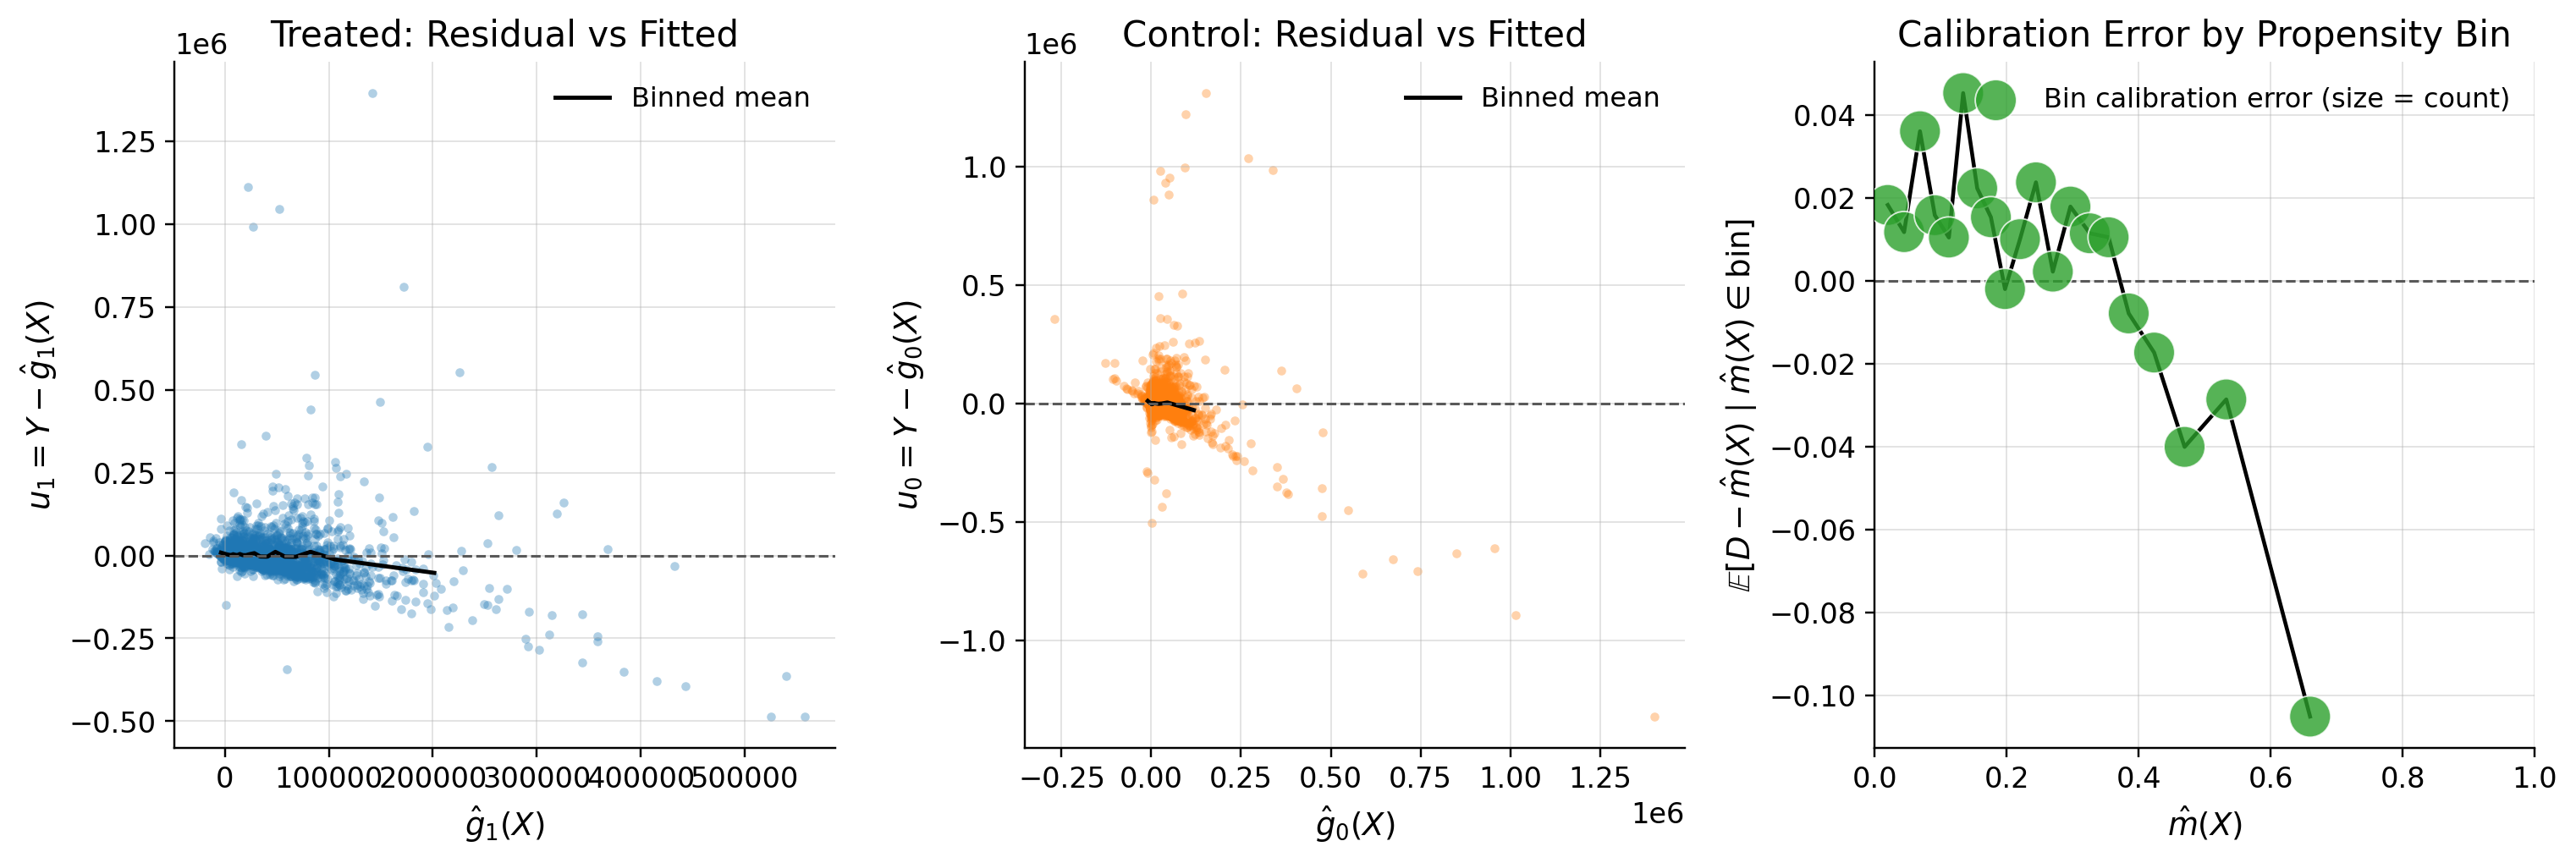

In [22]:
from causalis.scenarios.unconfoundedness.refutation import plot_residual_diagnostics
plot_residual_diagnostics(dml_result)

## Overlap

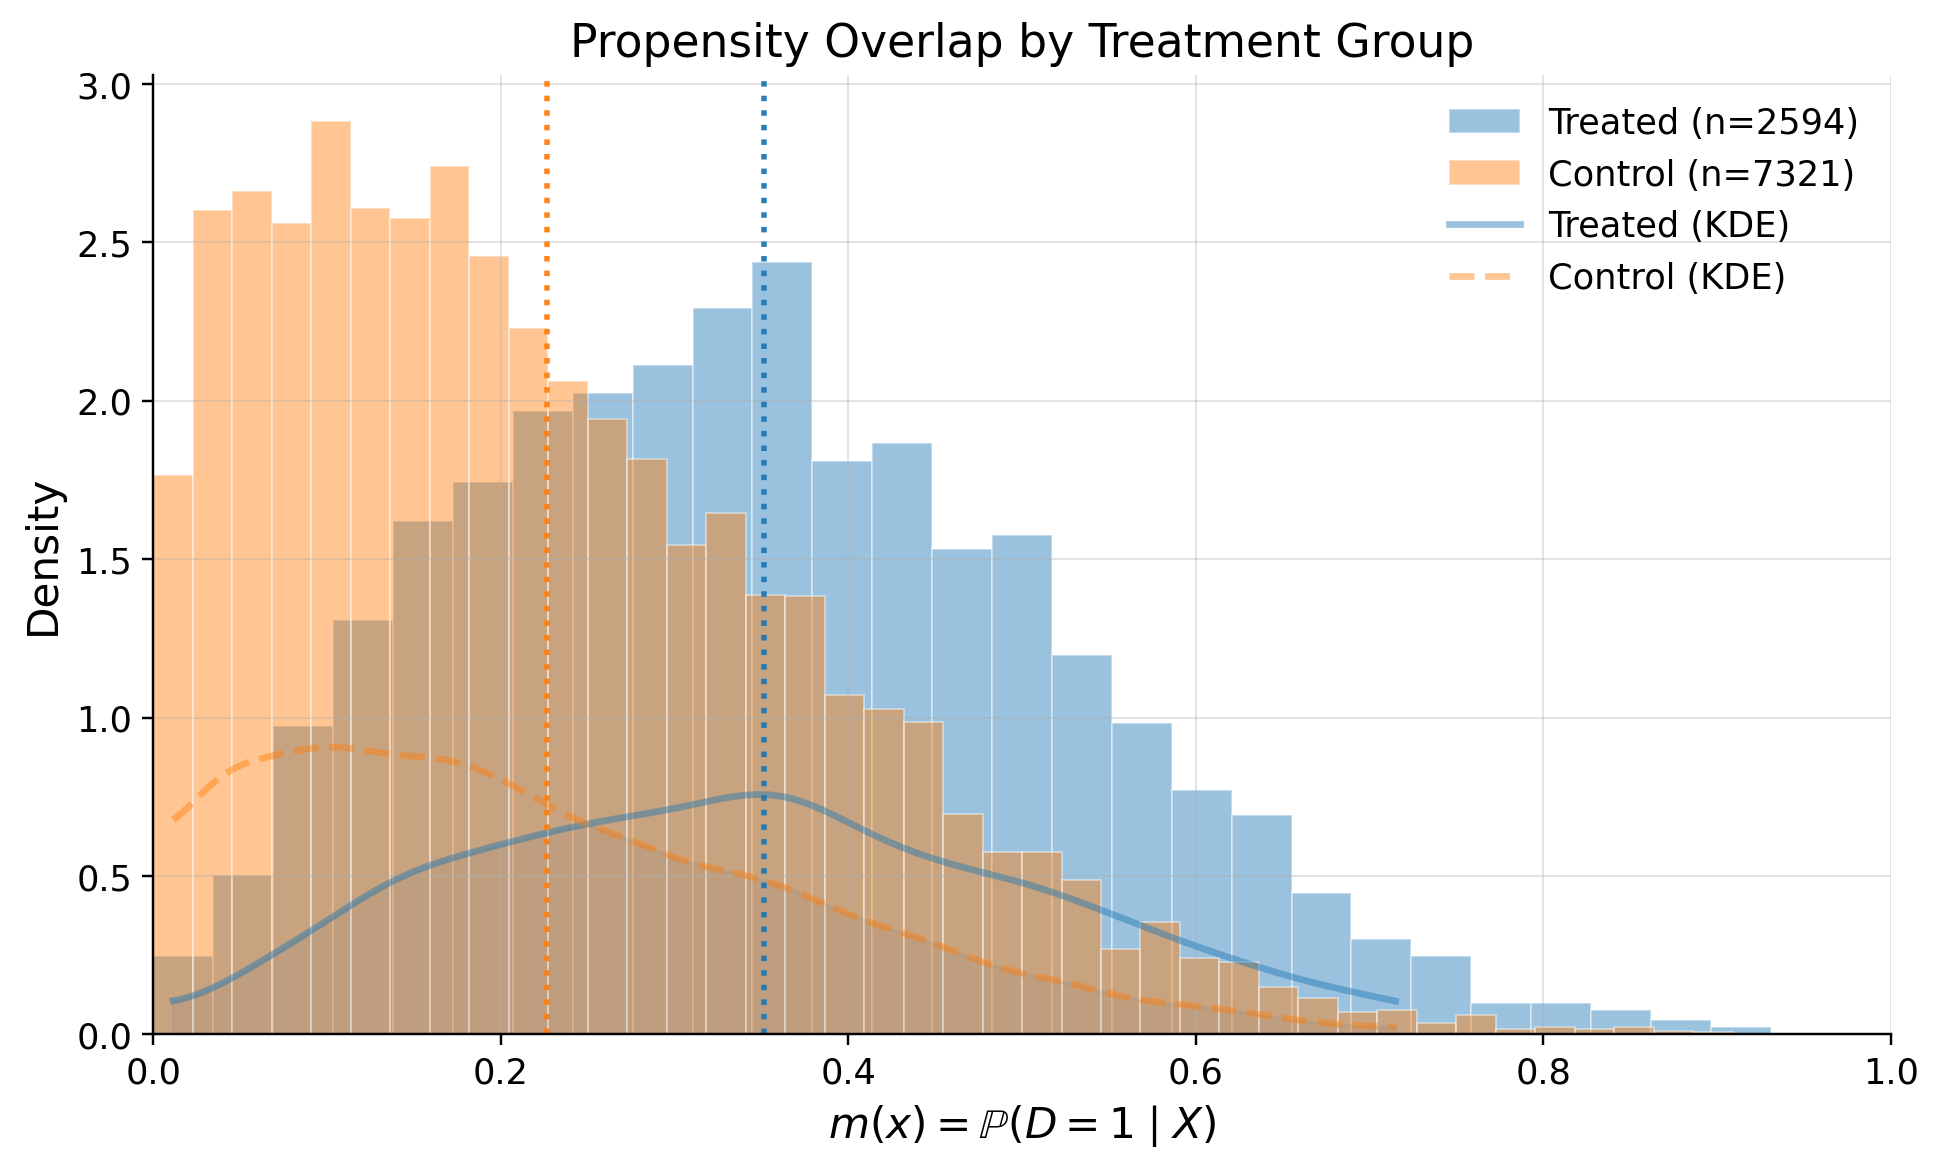

In [23]:
from causalis.scenarios.unconfoundedness.refutation import plot_m_overlap
plot_m_overlap(dml_result)

In [24]:
from causalis.scenarios.unconfoundedness.refutation import run_overlap_diagnostics
rep = run_overlap_diagnostics(causaldata, dml_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.008472,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.024307,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.316022,YELLOW
5,AUC,0.711829,GREEN
6,ESS_treated_ratio,0.383340,GREEN
7,ESS_control_ratio,0.903632,GREEN
8,tails_w1_q99/med,7.777954,YELLOW
9,tails_w0_q99/med,2.375994,GREEN


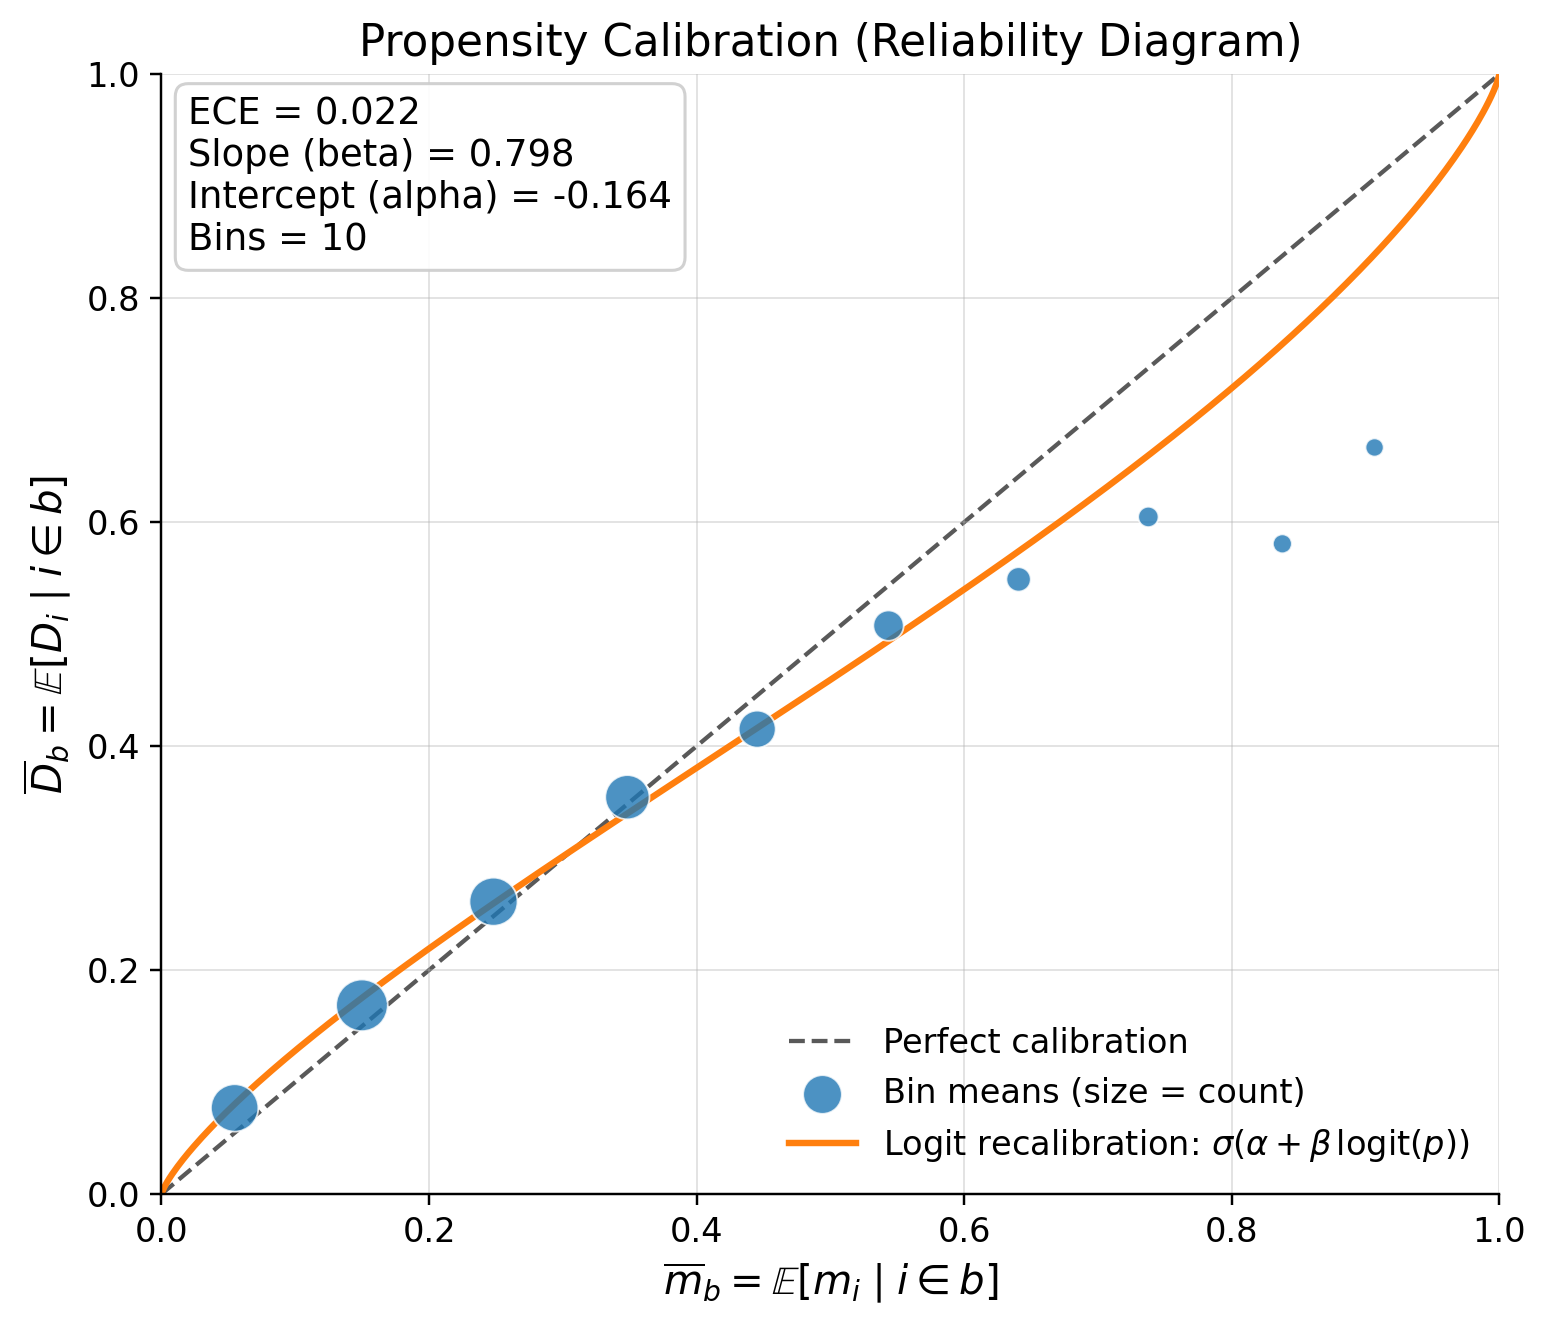

In [25]:
from causalis.scenarios.unconfoundedness.refutation import plot_propensity_reliability
plot_propensity_reliability(dml_result)

We find no evidence of a violation of the overlap (positivity) assumption.

## Conclution

There are problems with design: confounders are measured not before treatment. So treatment affected confounders.
However estimate is robust and in real life participation in 401k is increasing net financial assets. To keep in mind real CI bounds may differ from our estimation